In [1]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import cifar100
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage.transform import resize
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator

In [2]:
num_classes = 100

(x_train, y_train), (x_test, y_test) = cifar100.load_data()

169017344/169001437 [==============================] - 11s 0us/step


In [3]:
x_val = x_train[40000:50000, ]
x_train = x_train[:40000, ]
y_val = y_train[40000:50000]
y_train = y_train[:40000]
print(x_train.shape, y_train.shape)

(40000, 32, 32, 3) (40000, 1)


In [4]:
import cv2
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for keras'
    def __init__(self, images , labels = None,  batch_size = 64,
                 dim = (224, 224), n_classes = 100,
                 shuffle = True):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.dim = dim
        self.n_classes = n_classes
        self.shuffle = shuffle
        
        self.indexes = np.arange(self.images.shape[0]) # (0,1,2,3,...,40000)

        self.on_epoch_end()
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        
        if self.shuffle == True:
            np.random.shuffle(self.indexes) 
            
    def __len__(self):
        'Denotes the number of batches per epoch'
        return self.images.shape[0] // self.batch_size 
        
    def __getitem__(self, index):
        'Generate batch of data in position index'
        # index * batch_size : (index +1) *batch_size

        batch_indexes = self.indexes[ index*self.batch_size:(index+1)*self.batch_size]
        
        images =[]
        labels =[] 

        for i in batch_indexes:

          img_i = self.images[i] 
          img_i = cv2.resize(img_i , self.dim )
          img_i = (img_i) / 127. - 1 

          # augm.... 
          images.append(img_i)

          label_i = self.labels[i]
          labels.append(label_i)
      
        images = np.stack(images) # batch_size, 224,224,3
        labels = np_utils.to_categorical(labels, self.n_classes)

        return images, labels 

In [5]:
resnet_model = ResNet50(weights='imagenet', include_top=False,
                        input_shape=(224,224,3))
avg = GlobalAveragePooling2D()(resnet_model.output)

# den1 = Dense(256, activation=None)(avg)
# bn = BatchNormalization()(den1)
# relu = tf.keras.layers.Activation('relu')(bn)

drop1 = Dropout(0.3)(avg)
den2 = Dense(num_classes, activation='softmax')(drop1)

model = tf.keras.Model(inputs = resnet_model.inputs, outputs =[den2])


94781440/94765736 [==============================] - 1s 0us/step


In [6]:
for layer in resnet_model.layers:
  if isinstance(layer, BatchNormalization):
    layer.trainable = True
  else:
    layer.trainable = False
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [7]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
data_gen = DataGenerator(
    x_train,
    y_train,
    batch_size = 64,
    dim = (224, 224), n_classes = 100,
    shuffle = True
)
val_gen  = DataGenerator(
    x_val,
    y_val,
    batch_size = 64,
    dim = (224, 224), n_classes = 100,
    shuffle = False
)

Freeze pre-train and warm up top layers

In [8]:
t=time.time()
bt_size = 64 
Epoch = 5
historytemp = model.fit(data_gen,
                        validation_data=val_gen,
                        epochs=Epoch)
print('Training time: %s' % (time.time() - t))

Epoch 1/5
625/625 [==============================] - 705s 1s/step - loss: 1.9507 - accuracy: 0.4897 - val_loss: 4.7803 - val_accuracy: 0.1278
Epoch 2/5
625/625 [==============================] - 667s 1s/step - loss: 1.0077 - accuracy: 0.7042 - val_loss: 1.0163 - val_accuracy: 0.7093
Epoch 3/5
625/625 [==============================] - 670s 1s/step - loss: 0.7903 - accuracy: 0.7612 - val_loss: 0.9129 - val_accuracy: 0.7373
Epoch 4/5
625/625 [==============================] - 672s 1s/step - loss: 0.6606 - accuracy: 0.7961 - val_loss: 0.8888 - val_accuracy: 0.7468
Epoch 5/5
625/625 [==============================] - 673s 1s/step - loss: 0.5754 - accuracy: 0.8169 - val_loss: 0.8837 - val_accuracy: 0.7514
Training time: 3386.941650390625


In [9]:
test_gen = DataGenerator(
    x_test,
    y_test,
    batch_size = 64,
    dim = (224, 224), n_classes = 100,
    shuffle = False
)


In [11]:
model.evaluate(test_gen)

156/156 [==============================] - 66s 425ms/step - loss: 0.8507 - accuracy: 0.7555


[0.8506616353988647, 0.7555088400840759]

Unfreeze pre-train model, update entire model

In [10]:
# unfreeze weights
for layer in resnet_model.layers:
    layer.trainable = True

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3),
              metrics=['accuracy'])

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor = 'val_loss', mode = 'min',
                   patience = 8, restore_best_weights = True, verbose = 1)

In [17]:
hist = model.fit(data_gen,
                        validation_data=val_gen,
                  epochs=25,
                  callbacks=[es],
                  verbose=1
                  )


Epoch 1/25
625/625 [==============================] - 893s 1s/step - loss: 0.3555 - accuracy: 0.8892 - val_loss: 0.8391 - val_accuracy: 0.7624
Epoch 2/25
625/625 [==============================] - 890s 1s/step - loss: 0.3265 - accuracy: 0.8981 - val_loss: 0.8018 - val_accuracy: 0.7729
Epoch 3/25
625/625 [==============================] - 890s 1s/step - loss: 0.2988 - accuracy: 0.9101 - val_loss: 0.8003 - val_accuracy: 0.7728
Epoch 4/25
625/625 [==============================] - 883s 1s/step - loss: 0.2674 - accuracy: 0.9204 - val_loss: 0.7796 - val_accuracy: 0.7835
Epoch 5/25
625/625 [==============================] - 881s 1s/step - loss: 0.2428 - accuracy: 0.9294 - val_loss: 0.8080 - val_accuracy: 0.7742
Epoch 6/25
625/625 [==============================] - 899s 1s/step - loss: 0.2230 - accuracy: 0.9353 - val_loss: 0.7852 - val_accuracy: 0.7761
Epoch 7/25
625/625 [==============================] - 881s 1s/step - loss: 0.2070 - accuracy: 0.9404 - val_loss: 0.7901 - val_accuracy: 0.7774

In [19]:
model.save_weights("./model_nodense_drop_03.h5")

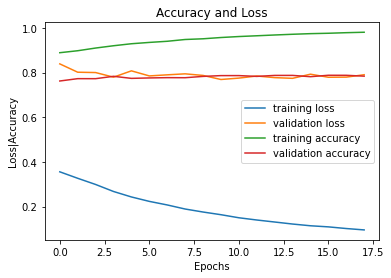

In [20]:
bs = 18
plt.plot(np.arange(0, bs), hist.history['loss'], label='training loss')
plt.plot(np.arange(0, bs), hist.history['val_loss'], label='validation loss')
plt.plot(np.arange(0, bs), hist.history['accuracy'], label='training accuracy')
plt.plot(np.arange(0, bs), hist.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss|Accuracy')
plt.legend()
plt.show()

In [21]:
model.evaluate(test_gen)

156/156 [==============================] - 66s 421ms/step - loss: 0.7412 - accuracy: 0.7892


[0.7412276864051819, 0.7891626358032227]